In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
torch:  1.12 ; cuda:  1.12.0
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg

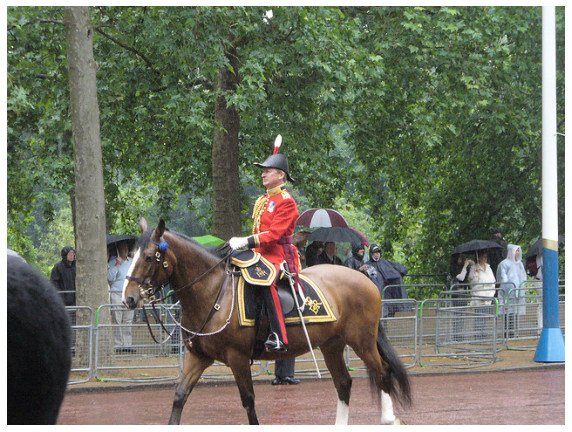

In [4]:
im = cv2.cvtColor(cv2.imread("./input.jpg"), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(im)

In [5]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:43, 4.11MB/s]                               
/opt/conda/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


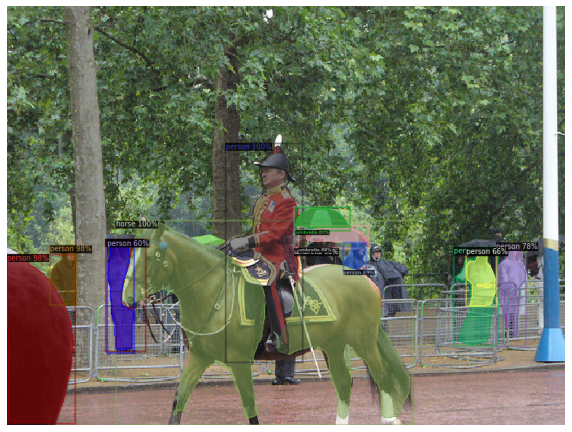

In [9]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(out.get_image()[:, :, ::-1])

# saving model and downloading dataset

In [10]:
torch.save(predictor.model.state_dict(), "mymodel.pth")

После загрузки датасета необходимо перенести изображения в datasets/coco/val2017, аннотации в datasets/coco/annotations

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Export to onnx

In [38]:
!python detectron2/tools/deploy/export_model.py --config-file detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml --sample-image ./demo.jpg --output ./checkpoints --export-method=tracing --format onnx MODEL.WEIGHTS mymodel.pth MODEL.DEVICE cuda

/opt/conda/lib/python3.7/site-packages/caffe2/__init__.py:5: UserWarning: Caffe2 support is not fully enabled in this PyTorch build. Please enable Caffe2 by building PyTorch from source with `BUILD_CAFFE2=1` flag.
  warnings.warn("Caffe2 support is not fully enabled in this PyTorch build. "
/opt/conda/lib/python3.7/site-packages/caffe2/proto/__init__.py:17: UserWarning: Caffe2 support is not enabled in this PyTorch build. Please enable Caffe2 by building PyTorch from source with `BUILD_CAFFE2=1` flag.
  warnings.warn('Caffe2 support is not enabled in this PyTorch build. '
[10/18 10:16:37 detectron2]: Command line arguments: Namespace(config_file='detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', export_method='tracing', format='onnx', opts=['MODEL.WEIGHTS', 'mymodel.pth', 'MODEL.DEVICE', 'cuda'], output='./checkpoints', run_eval=False, sample_image='./demo.jpg')
[W init.cpp:753] Warning: Use _jit_set_fusion_strategy, bailout depth is deprecated. Setting to (STAT

# ONNX inference

## Check model

In [39]:
import onnx

onnx_model = onnx.load("checkpoints/model.onnx")
onnx.checker.check_model(onnx_model)

## Preprocessing image

In [17]:
!wget https://github.com/onnx/models/raw/main/vision/object_detection_segmentation/mask-rcnn/dependencies/demo.jpg

--2022-10-18 09:51:43--  https://github.com/onnx/models/raw/main/vision/object_detection_segmentation/mask-rcnn/dependencies/demo.jpg
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/onnx/models/main/vision/object_detection_segmentation/mask-rcnn/dependencies/demo.jpg [following]
--2022-10-18 09:51:47--  https://raw.githubusercontent.com/onnx/models/main/vision/object_detection_segmentation/mask-rcnn/dependencies/demo.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171271 (167K) [image/jpeg]
Saving to: ‘demo.jpg’

demo.jpg            100%[===================>] 167.26K   740KB/s    in 0.2s    

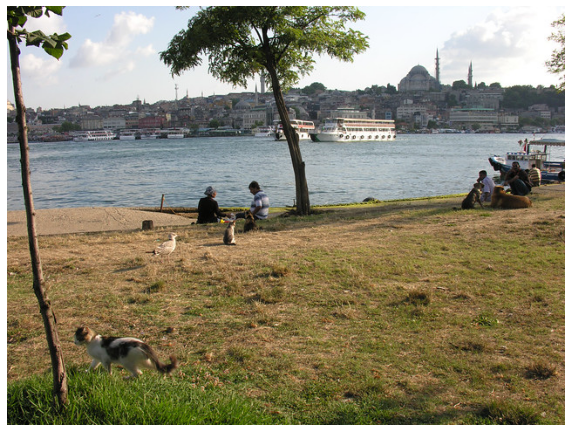

In [23]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(plt.imread("demo.jpg"))

In [74]:
# https://github.com/onnx/models/tree/main/vision/object_detection_segmentation/mask-rcnn

import numpy as np
from PIL import Image
import torchvision.transforms as transforms


def preprocess(image):
    # Resize
    # ratio = 800.0 / min(image.size[0], image.size[1])
    # image = image.resize((int(ratio * image.size[0]), int(ratio * image.size[1])), Image.BILINEAR)
    image = image.resize((1067, 800), Image.BILINEAR)

    # Convert to BGR
    image = np.array(image)[:, :, [2, 1, 0]].astype('float32')

    # HWC -> CHW
    image = np.transpose(image, [2, 0, 1])

    # Normalize
    mean_vec = np.array([102.9801, 115.9465, 122.7717])
    for i in range(image.shape[0]):
        image[i, :, :] = image[i, :, :] - mean_vec[i]

    # # Pad to be divisible of 32
    # import math
    # padded_h = int(math.ceil(image.shape[1] / 32) * 32)
    # padded_w = int(math.ceil(image.shape[2] / 32) * 32)
    # padded_image = np.zeros((3, padded_h, padded_w), dtype=np.float32)
    # padded_image[:, :image.shape[1], :image.shape[2]] = image
    # image = padded_image
    # print(type(image))
    # print(image.shape)
    return image

img = Image.open('demo.jpg')
print(img.size)
img_data = preprocess(img)

(640, 480)


## Inference

In [83]:
import onnxruntime as ort

providers = [
    ('CUDAExecutionProvider', {
        'device_id': 0,
        'arena_extend_strategy': 'kNextPowerOfTwo',
        'gpu_mem_limit': 2 * 1024 * 1024 * 1024,
        'cudnn_conv_algo_search': 'EXHAUSTIVE',
        'do_copy_in_default_stream': True,
    }),
    'CPUExecutionProvider',
]

ort_session = ort.InferenceSession("checkpoints/model.onnx", providers=providers)

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: img_data}
ort_outs = ort_session.run(None, ort_inputs)

## Postprocessing

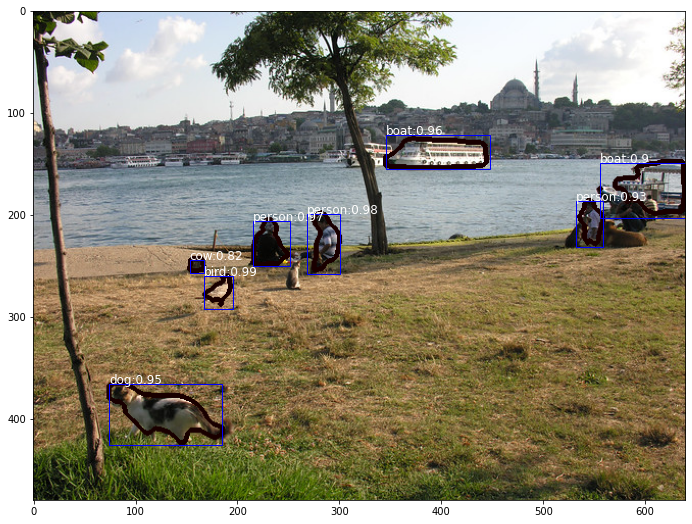

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pycocotools.mask as mask_util
import cv2

classes = [
    'person',
    'bicycle',
    'car',
    'motorcycle',
    'airplane',
    'bus',
    'train',
    'truck',
    'boat',
    'traffic light',
    'fire hydrant',
    'stop sign',
    'parking meter',
    'bench',
    'bird',
    'cat',
    'dog',
    'horse',
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    'backpack',
    'umbrella',
    'handbag',
    'tie',
    'suitcase',
    'frisbee',
    'skis',
    'snowboard',
    'sports ball',
    'kite',
    'baseball bat',
    'baseball glove',
    'skateboard',
    'surfboard',
    'tennis racket',
    'bottle',
    'wine glass',
    'cup',
    'fork',
    'knife',
    'spoon',
    'bowl',
    'banana',
    'apple',
    'sandwich',
    'orange',
    'broccoli',
    'carrot',
    'hot dog',
    'pizza',
    'donut',
    'cake',
    'chair',
    'couch',
    'potted plant',
    'bed',
    'dining table',
    'toilet',
    'tv',
    'laptop',
    'mouse',
    'remote',
    'keyboard',
    'cell phone',
    'microwave',
    'oven',
    'toaster',
    'sink',
    'refrigerator',
    'book',
    'clock',
    'vase',
    'scissors',
    'teddy bear',
    'hair drier',
    'toothbrush'
]

def display_objdetect_image(image, boxes, labels, scores, masks, score_threshold=0.7):
    # Resize boxes
    ratio = 800.0 / min(image.size[0], image.size[1])
    boxes /= ratio

    _, ax = plt.subplots(1, figsize=(12,9))

    image = np.array(image)

    for mask, box, label, score in zip(masks, boxes, labels, scores):
        # Showing boxes with score > 0.7
        if score <= score_threshold:
            continue

        # Finding contour based on mask
        mask = mask[0, :, :, None]
        int_box = [int(i) for i in box]
        mask = cv2.resize(mask, (int_box[2]-int_box[0]+1, int_box[3]-int_box[1]+1))
        mask = mask > 0.5
        im_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        x_0 = max(int_box[0], 0)
        x_1 = min(int_box[2] + 1, image.shape[1])
        y_0 = max(int_box[1], 0)
        y_1 = min(int_box[3] + 1, image.shape[0])
        mask_y_0 = max(y_0 - box[1], 0)
        mask_y_1 = mask_y_0 + y_1 - y_0
        mask_x_0 = max(x_0 - box[0], 0)
        mask_x_1 = mask_x_0 + x_1 - x_0
        im_mask[y_0:y_1, x_0:x_1] = mask[
            mask_y_0 : mask_y_1, mask_x_0 : mask_x_1
        ]
        im_mask = im_mask[:, :, None]

        # OpenCV version 4.x
        contours, hierarchy = cv2.findContours(
            im_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )

        image = cv2.drawContours(image, contours, -1, 25, 3)

        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='b', facecolor='none')
        ax.annotate(classes[label] + ':' + str(np.round(score, 2)), (box[0], box[1]), color='w', fontsize=12)
        ax.add_patch(rect)

    ax.imshow(image)
    plt.show()

    
img = Image.open('demo.jpg')
boxes = ort_outs[0].copy()
labels = ort_outs[1].copy()
scores = ort_outs[3].copy()
masks = ort_outs[2].copy()

display_objdetect_image(img, boxes, labels, scores, masks, score_threshold=0.7)